# BUSCO Error Log Analysis

Analysis of `error_log.tsv` — annotations may appear multiple times due to retries.
We focus on four questions:
1. What **error categories** exist and how frequent are they?
2. How many annotations **recovered** after failing?
3. What errors did recovered annotations **overcome**?
4. Which errors **persist** unchanged across retries?

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

GRAY = ["#E0E0E0", "#B0B0B0", "#808080", "#505050", "#202020"]

plt.rcParams.update({"axes.grid": True, "grid.alpha": 0.3})

errors = pd.read_csv("../BUSCO/eukaryota_odb12/error_log.tsv", sep="\t")
busco = pd.read_csv("../BUSCO/eukaryota_odb12/BUSCO.tsv", sep="\t")
errors["run_at"] = pd.to_datetime(errors["run_at"])

def classify_error(step):
    step = str(step)
    if "HTTP 403" in step:
        return "HTTP 403 (Forbidden)"
    elif "HTTP 404" in step:
        return "HTTP 404 (Not Found)"
    elif "HTTP 5" in step:
        return "HTTP 5xx (Server Error)"
    elif "couldn't find fasta record" in step:
        return "Sequence ID mismatch"
    elif "gffread" in step or "extraction" in step.lower():
        return "GFF/FASTA processing"
    elif "busco" in step.lower():
        return "BUSCO analysis"
    else:
        return "Other"

errors["category"] = errors["step"].apply(classify_error)

# Recovery status
error_ids = set(errors["annotation_id"])
success_ids = set(busco["annotation_id"])
recovered_ids = error_ids & success_ids
persistent_ids = error_ids - success_ids

errors["status"] = errors["annotation_id"].map(
    lambda x: "Recovered" if x in recovered_ids else "Persistent"
)

# Failure counts per annotation
failure_counts = errors.groupby("annotation_id").agg(
    attempts=("annotation_id", "size"),
    status=("status", "first")
).reset_index()

print(f"Error entries: {len(errors)}  |  Unique annotations: {len(error_ids)}")
print(f"Recovered: {len(recovered_ids)}  |  Persistent: {len(persistent_ids)}")

Error entries: 4433  |  Unique annotations: 1704
Recovered: 882  |  Persistent: 822


## 1. Error Categories

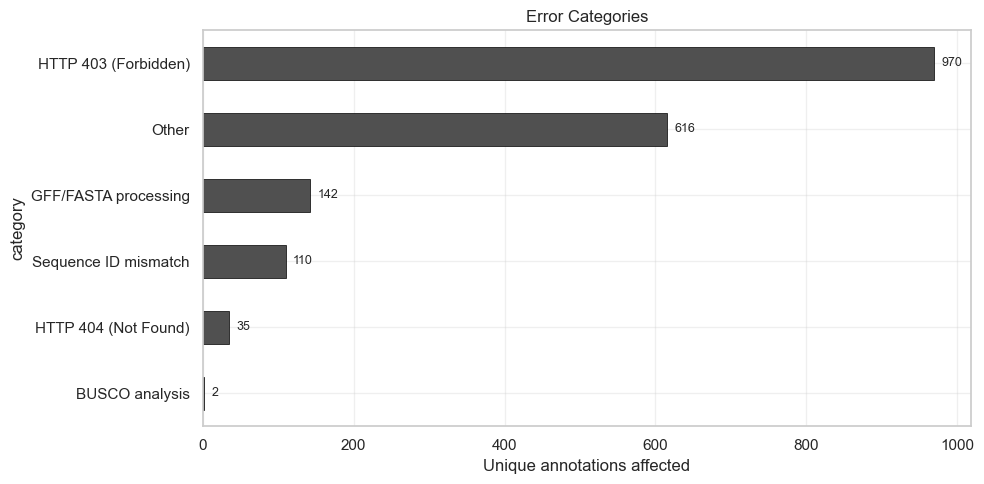

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

cat_counts = errors.groupby("category")["annotation_id"].nunique().sort_values()
cat_counts.plot.barh(ax=ax, color=GRAY[3], edgecolor="black", linewidth=0.5)
for i, (v, cat) in enumerate(zip(cat_counts.values, cat_counts.index)):
    ax.text(v + cat_counts.max() * 0.01, i, str(v), va="center", fontsize=9)

ax.set_xlabel("Unique annotations affected")
ax.set_title("Error Categories")
plt.tight_layout()
plt.show()

## 2. Recovery: Failed → Succeeded

Annotations that appear in both the error log and `BUSCO.tsv` — they failed at least once but eventually completed.

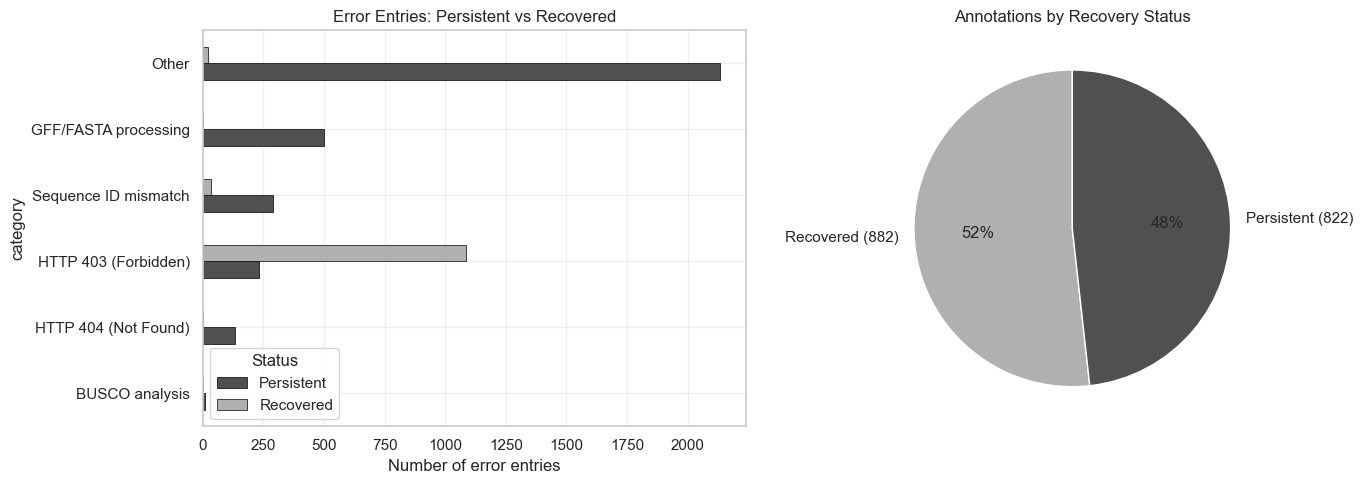

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: recovered vs persistent by category
ct = pd.crosstab(errors["category"], errors["status"]).sort_values("Persistent")
ct.plot.barh(ax=axes[0], color=[GRAY[3], GRAY[1]], edgecolor="black", linewidth=0.5)
axes[0].set_xlabel("Number of error entries")
axes[0].set_title("Error Entries: Persistent vs Recovered")
axes[0].legend(title="Status")

# Right: pie chart of unique annotations
sizes = [len(recovered_ids), len(persistent_ids)]
labels = [f"Recovered ({sizes[0]})", f"Persistent ({sizes[1]})"]
axes[1].pie(sizes, labels=labels, autopct="%1.0f%%", colors=[GRAY[1], GRAY[3]], startangle=90)
axes[1].set_title("Annotations by Recovery Status")

plt.tight_layout()
plt.show()

## 3. What Errors Did Recovered Annotations Overcome?

For each recovered annotation, what was the **last error** logged before it succeeded?

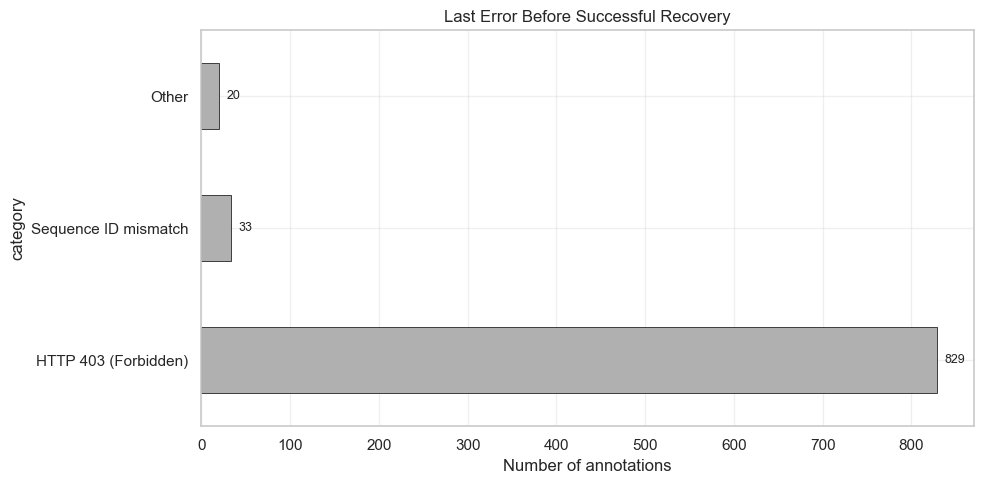

In [20]:
recovered_errors = errors[errors["annotation_id"].isin(recovered_ids)].sort_values("run_at")
last_error = recovered_errors.groupby("annotation_id")["category"].last().value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
last_error.plot.barh(ax=ax, color=GRAY[1], edgecolor="black", linewidth=0.5)
for i, (v, cat) in enumerate(zip(last_error.values, last_error.index)):
    ax.text(v + last_error.max() * 0.01, i, str(v), va="center", fontsize=9)

ax.set_xlabel("Number of annotations")
ax.set_title("Last Error Before Successful Recovery")
plt.tight_layout()
plt.show()

## 4. Persistent Errors: Same or Changing?

For annotations that **never recovered** and failed more than once: did they always hit the same error, or did the error category change across retries?

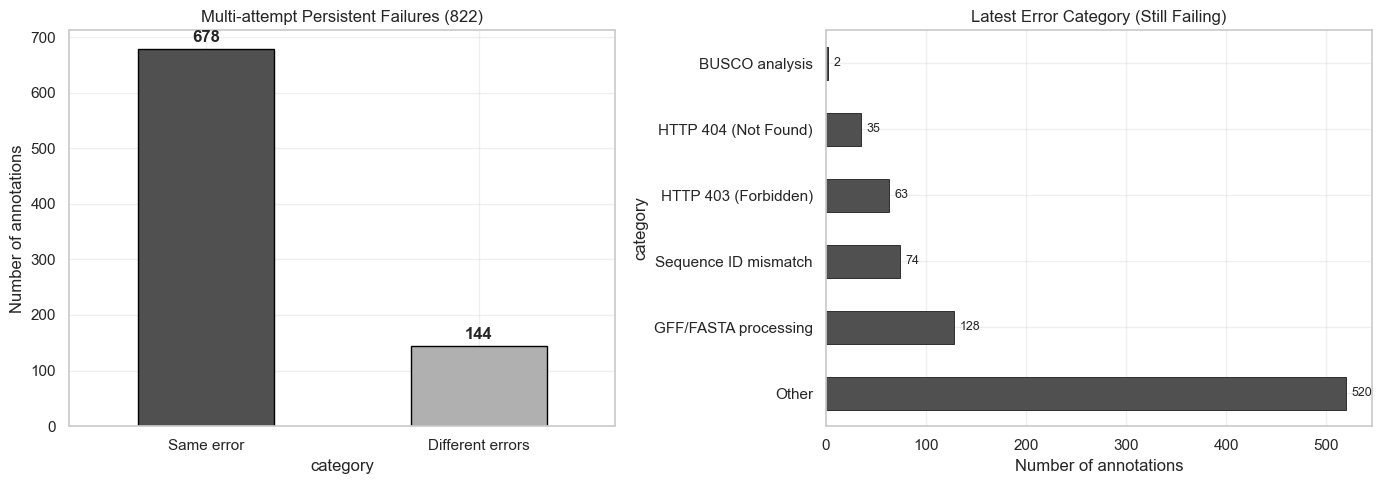

In [21]:
persistent_multi = errors[
    (errors["annotation_id"].isin(persistent_ids))
].sort_values(["annotation_id", "run_at"])

# Only look at annotations with >1 attempt
multi_ids = failure_counts[
    (failure_counts["attempts"] > 1) & (failure_counts["status"] == "Persistent")
]["annotation_id"]
persistent_multi = persistent_multi[persistent_multi["annotation_id"].isin(multi_ids)]

consistency = persistent_multi.groupby("annotation_id")["category"].apply(
    lambda x: "Same error" if x.nunique() == 1 else "Different errors"
).value_counts()

# Latest error category for all persistent annotations
latest_cat = (
    errors[errors["annotation_id"].isin(persistent_ids)]
    .sort_values("run_at")
    .groupby("annotation_id")["category"]
    .last()
    .value_counts()
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: consistency
if len(consistency) > 0:
    consistency.plot.bar(ax=axes[0], color=[GRAY[3], GRAY[1]], edgecolor="black", width=0.5)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    for i, v in enumerate(consistency.values):
        axes[0].text(i, v + consistency.max() * 0.02, str(v), ha="center", fontweight="bold")
axes[0].set_ylabel("Number of annotations")
axes[0].set_title(f"Multi-attempt Persistent Failures ({len(multi_ids)})")

# Right: latest error category
latest_cat.plot.barh(ax=axes[1], color=GRAY[3], edgecolor="black", linewidth=0.5)
for i, (v, cat) in enumerate(zip(latest_cat.values, latest_cat.index)):
    axes[1].text(v + latest_cat.max() * 0.01, i, str(v), va="center", fontsize=9)
axes[1].set_xlabel("Number of annotations")
axes[1].set_title("Latest Error Category (Still Failing)")

plt.tight_layout()
plt.show()

## Summary

In [22]:
n = errors["annotation_id"].nunique()
r = len(recovered_ids)
p = len(persistent_ids)

print(f"{'Error log entries':<35}: {len(errors)}")
print(f"{'Unique annotations with errors':<35}: {n}")
print(f"{'Recovered (failed -> succeeded)':<35}: {r} ({100*r/n:.0f}%)")
print(f"{'Persistent (still failing)':<35}: {p} ({100*p/n:.0f}%)")
print()
print("Error categories (unique annotations):")
for cat, count in errors.groupby("category")["annotation_id"].nunique().sort_values(ascending=False).items():
    print(f"  {cat:<30} {count:>5}")

Error log entries                  : 4433
Unique annotations with errors     : 1704
Recovered (failed -> succeeded)    : 882 (52%)
Persistent (still failing)         : 822 (48%)

Error categories (unique annotations):
  HTTP 403 (Forbidden)             970
  Other                            616
  GFF/FASTA processing             142
  Sequence ID mismatch             110
  HTTP 404 (Not Found)              35
  BUSCO analysis                     2
